In [0]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import bokeh as bk
import folium
from pandas import Series, DataFrame
import datetime

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Data Pre-processing**


In [0]:
# Loading the data set
virus = pd.DataFrame(pd.read_csv("/content/drive/My Drive/datasets/Covid_Global.csv"))
China = pd.DataFrame(pd.read_csv('/content/drive/My Drive/datasets/Covid-China.csv'))

In [0]:
virus.drop(columns={'provinceEnglishName','report_date'}, inplace=True)

In [0]:
columns_replaced={'countryEnglishName':'country',
                        'total_confirmedCount':'total_cases',
                        'total_curedCount':'total_cured',
                        'total_deadCount':'total_death'}
virus.rename(columns=columns_replaced, inplace=True)
China.rename(columns=columns_replaced, inplace=True)

In [0]:
# Changing the "report_data" column to a time attribute to facilitate sorting
virus['date'] = virus['updateTime'].str[0:10]
virus.date = pd.to_datetime(virus.date, format='%d/%m/%Y')
virus.sort_values('updateTime', ascending = False, inplace=True)
# virus.drop(columns={'report_date'}, inplace=True)

In [0]:
China['date'] = China['updateTime']
China.date = pd.to_datetime(China.date, format='%d/%m/%Y')
# virus.drop(columns={'report_date'}, inplace=True)

In [0]:
virus.drop(virus[virus.country == 'China'].index, inplace=True)

In [749]:
# virus.sort_values(['date'],ascending=False,inplace=True)
# Taking the first row as the data for the day
grouped = virus.groupby(['country','date']).head(1)
grouped.dropna(axis=0, how='any', inplace=True)
virus.drop(columns='updateTime', inplace=True)
virus.reset_index(drop=True, inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
grouped = pd.concat([grouped, China], axis=0)

In [0]:
grouped.sort_values('date', inplace=True, ascending=True)

In [752]:
grouped[grouped['country']=='China']

,country,total_cases,total_cured,total_death,updateTime,date
0,China,44,2,1,11/01/2020,2020-01-11
1,China,44,6,1,12/01/2020,2020-01-12
2,China,44,7,1,13/01/2020,2020-01-13
3,China,44,7,1,14/01/2020,2020-01-14
4,China,44,7,1,15/01/2020,2020-01-15
...,...,...,...,...,...,...
59,China,80714,61479,3157,11/03/2020,2020-03-11
60,China,80722,62797,3168,12/03/2020,2020-03-12
61,China,80727,64109,3175,13/03/2020,2020-03-13
62,China,80743,65560,3188,14/03/2020,2020-03-14


In [0]:
virus_new = pd.DataFrame(
    columns=['date', 'country', 'new_cases', 'cured', 'total_cured', 'death', 'total_death', 'total_cases',
             'current_total_cases',
             'cured_rate', 'death_rate'])

virus.date = pd.to_datetime(virus.date)
groups = grouped.groupby('country')
for i in groups:
    country = i[0]
    date_list = i[1]
    for k in i[1].values:
        total_cases = k[1]
        total_cured = k[2]
        total_dead = k[3]
        report_date = k[5]

        cure_rate = 0
        death_rate = 0
        if total_cases != 0:
            cure_rate = round(total_cured / total_cases, 4)
            death_rate = round(total_dead / total_cases, 4)

        # get the date of yesterday
        current_date = pd.to_datetime(report_date)
        yesterday = str((current_date + datetime.timedelta(seconds=-1)))[0:10]  # extracted the value of year, month and day
        
        yesterday_date = date_list[date_list['date'] == yesterday]

        new_cases = 0
        cured = 0
        death = 0
        try:
            new_cases = total_cases - int(yesterday_date['total_confirmedCount'])
            cured = total_cured - int(yesterday_date['total_curedCount'])
            death = total_dead - int(yesterday_date['total_deadCount'])
        except Exception as e:
            repr(e)

        current_total_cases = total_cases - total_cured - total_dead

        virus_new = virus_new.append({'date': report_date, 'country': country, 'new_cases': new_cases, 'cured': cured,
                                      'total_cured': total_cured, 'death': death, 'total_death': total_dead,
                                      'total_cases': total_cases, 'current_total_cases': current_total_cases,
                                      'cured_rate': cure_rate, 'death_rate': death_rate}, ignore_index=True)

# Data Visulization(Italy,Germany and Ireland)

In [0]:
# plotting
############################  Analyzing Italy, Germany, Ireland  ########################################
Italy_data = virus_new[virus_new["country"]=="Italy"]
Italy_data.set_index('date',inplace=True)

Germany_data = virus_new[virus_new["country"]=="Germany"]
Germany_data.set_index('date',inplace=True)

Ireland_data= virus_new[virus_new["country"]=="Ireland"]
Ireland_data.set_index('date',inplace=True)

China_data = virus_new[virus_new['country']=='China']
China_data.set_index('date',inplace=True)

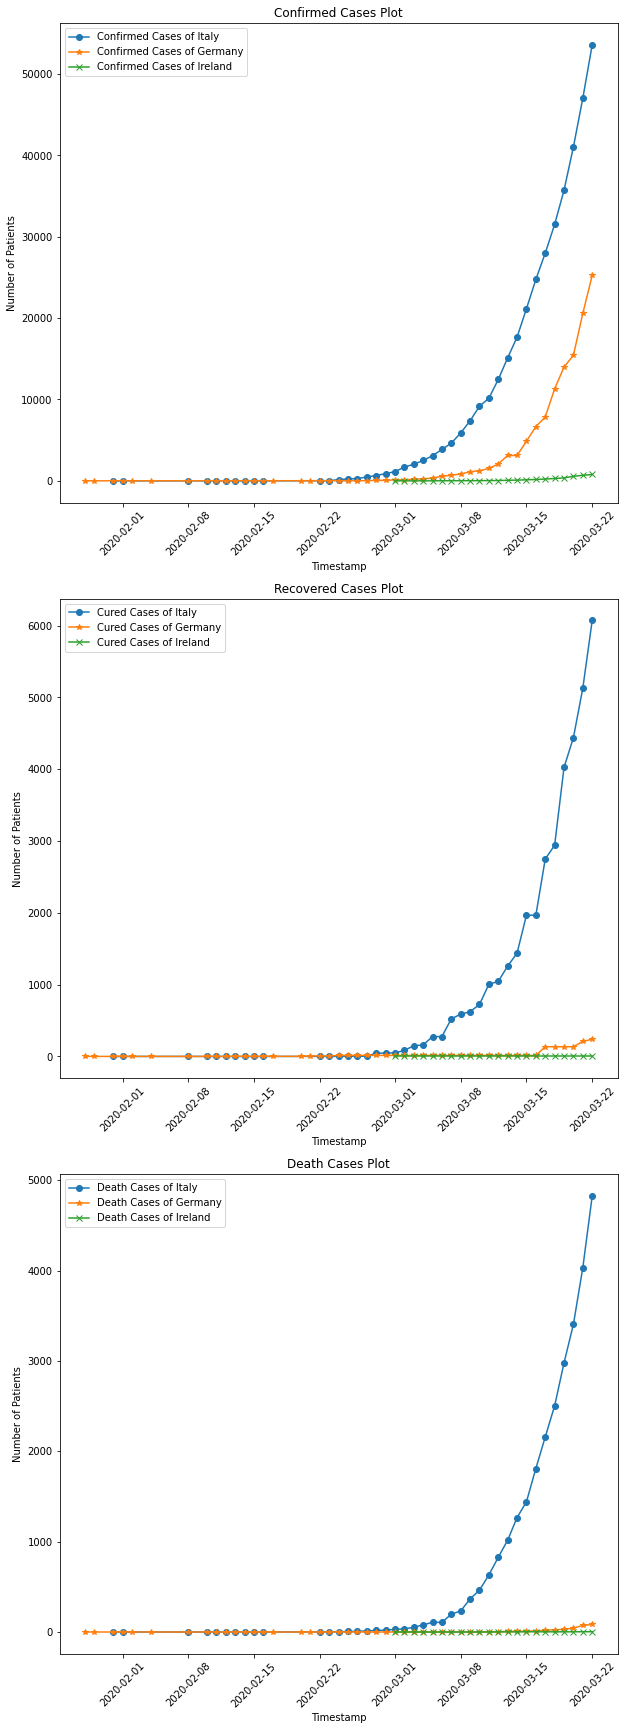

In [756]:
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,figsize=(10,30))
# total_cases
ax1.plot(Italy_data["total_cases"],label="Confirmed Cases of Italy",marker='o')
ax1.plot(Germany_data["total_cases"],label="Confirmed Cases of Germany",marker='*')
ax1.plot(Ireland_data["total_cases"],label="Confirmed Cases of Ireland",marker='x')
ax1.set_title("Confirmed Cases Plot")
ax1.set_ylabel("Number of Patients")
ax1.set_xlabel("Timestamp")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
# total_cured
ax2.plot(Italy_data["total_cured"],label="Cured Cases of Italy",marker='o')
ax2.plot(Germany_data["total_cured"],label="Cured Cases of Germany",marker='*')
ax2.plot(Ireland_data["total_cured"],label="Cured Cases of Ireland",marker='x')
ax2.set_title("Recovered Cases Plot")
ax2.set_ylabel("Number of Patients")
ax2.set_xlabel("Timestamp")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
# total_death 
ax3.plot(Italy_data["total_death"],label="Death Cases of Italy",marker='o')
ax3.plot(Germany_data["total_death"],label="Death Cases of Germany",marker='*')
ax3.plot(Ireland_data["total_death"],label="Death Cases of Ireland",marker='x')
ax3.set_title("Death Cases Plot")
ax3.set_ylabel("Number of Patients")
ax3.set_xlabel("Timestamp")
ax3.legend()
for tick in ax3.get_xticklabels():
    tick.set_rotation(45)

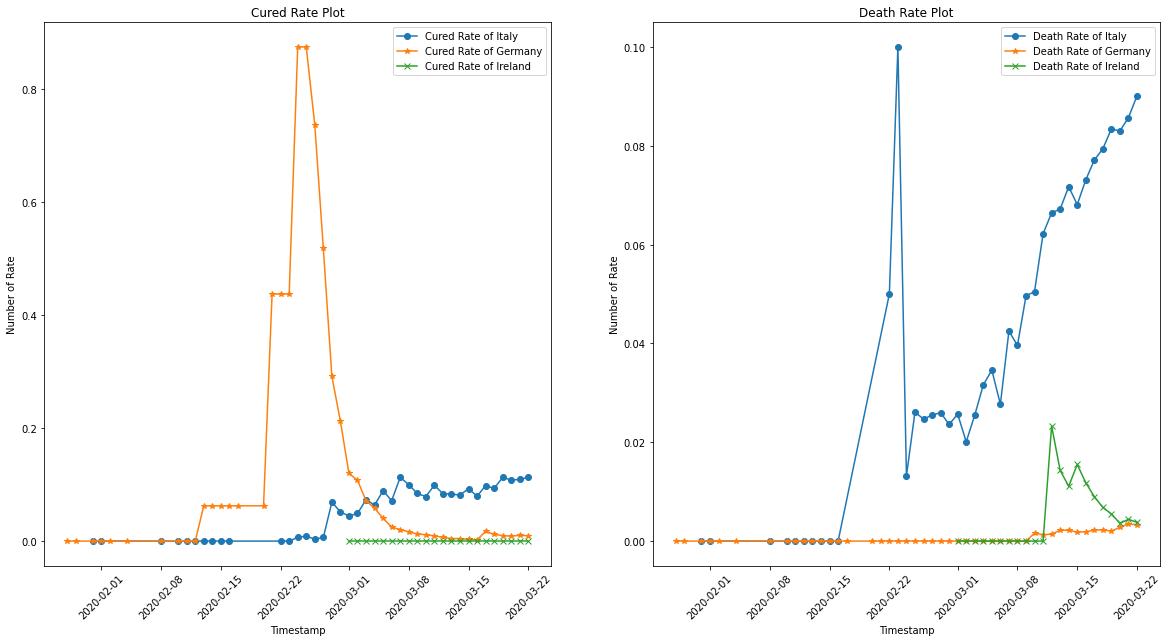

In [757]:
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
# cured_rate
ax1.plot(Italy_data["cured_rate"],label="Cured Rate of Italy",marker='o')
ax1.plot(Germany_data["cured_rate"],label="Cured Rate of Germany",marker='*')
ax1.plot(Ireland_data["cured_rate"],label="Cured Rate of Ireland",marker='x')
ax1.set_title("Cured Rate Plot")
ax1.set_ylabel("Number of Rate")
ax1.set_xlabel("Timestamp")
ax1.legend()
for tick in ax1.get_xticklabels():
    tick.set_rotation(45)
# death_rate
ax2.plot(Italy_data["death_rate"],label="Death Rate of Italy",marker='o')
ax2.plot(Germany_data["death_rate"],label="Death Rate of Germany",marker='*')
ax2.plot(Ireland_data["death_rate"],label="Death Rate of Ireland",marker='x')
ax2.set_title("Death Rate Plot")
ax2.set_ylabel("Number of Rate")
ax2.set_xlabel("Timestamp")
ax2.legend()
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)

Text(0.5, 1.0, 'three countries Number of Active Cases')

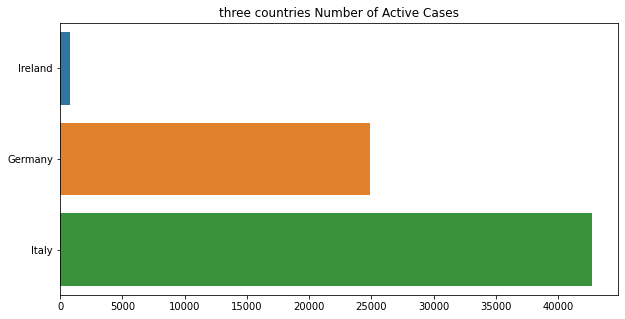

In [758]:
# current_total_cases
threeCountry = pd.concat([Italy_data,Germany_data,Ireland_data])
threeCountry.sort_values(['date'],ascending=False,inplace=True)
threeCountry_new = threeCountry.groupby(['country']).head(1)

# current_total_cases = threeCountry_new['current_total_cases']
x=np.array(threeCountry_new['current_total_cases'])
y=np.array(threeCountry_new['country'])
plt.figure(figsize=(10,5))
sns.barplot(x,y)
plt.title("three countries Number of Active Cases")

# Data Visulization (China)

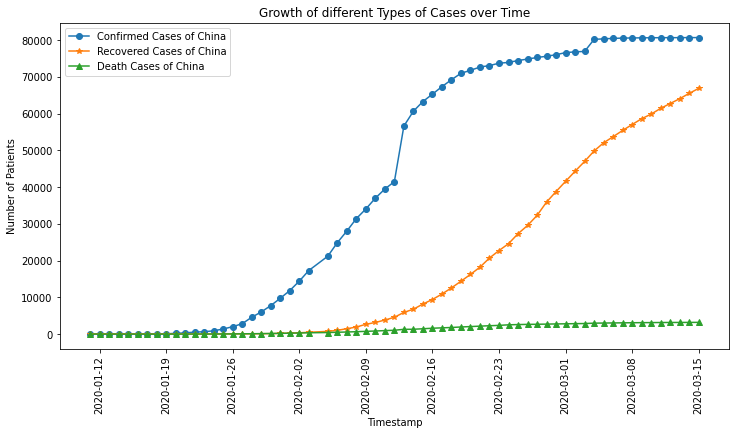

In [759]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import MultipleLocator
plt.figure(figsize=(12,6))
plt.plot(China_data.total_cases,marker="o",label="Confirmed Cases of China")
plt.plot(China_data.total_cured,marker="*",label="Recovered Cases of China")
plt.plot(China_data.total_death,marker="^",label="Death Cases of China")
plt.ylabel("Number of Patients")
plt.xlabel("Timestamp")
x_major_locator=MultipleLocator(7)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=90)
plt.title("Growth of different Types of Cases over Time")
plt.legend()

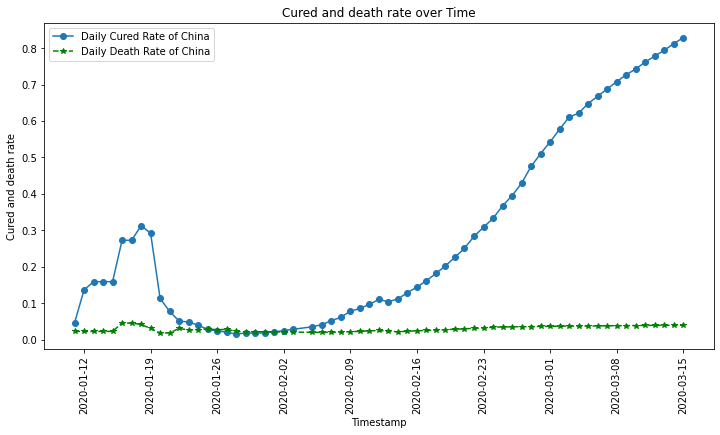

In [760]:
# Chinese cured rate and death rate
plt.figure(figsize=(12,6))
plt.plot(China_data.cured_rate, marker="o",label="Daily Cured Rate of China")
plt.plot(China_data.death_rate,'g--', marker="*",label="Daily Death Rate of China")

plt.ylabel("Cured and death rate")
plt.xlabel("Timestamp")
x_major_locator=MultipleLocator(7)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=90)
plt.title("Cured and death rate over Time")
plt.legend()

(array([737452., 737454., 737456., 737458., 737460., 737462., 737464.,
        737466., 737468., 737470., 737472., 737474., 737476., 737478.,
        737480., 737482., 737484., 737486., 737488., 737490., 737492.,
        737494., 737496., 737498., 737500., 737502., 737504., 737506.,
        737508., 737510.]), <a list of 30 Text major ticklabel objects>)

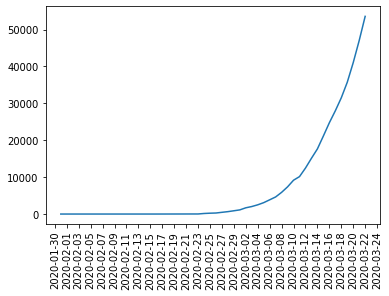

In [761]:
plt.plot(Italy_data.total_cases)
x_major_locator=MultipleLocator(2)
ax=plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
plt.xticks(rotation=90)

# Model Building(ARIMA)

###### Time series stationary testing

In [0]:
from statsmodels.tsa.stattools import kpss

result of KPSS test:
Test Statistic            0.429859
p-value                   0.064285
Lags-used                10.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
Critical value (2.5%)     0.574000
Critical value (1%)       0.739000
dtype: float64
result of KPSS test:
Test Statistic            0.175147
p-value                   0.100000
Lags-used                10.000000
Critical value (10%)      0.347000
Critical value (5%)       0.463000
Critical value (2.5%)     0.574000
Critical value (1%)       0.739000
dtype: float64


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


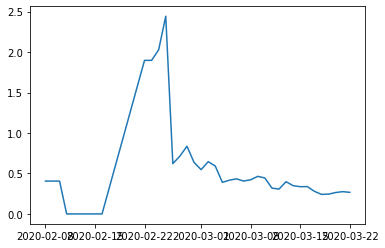

In [763]:
# Smoothing the inspection - KPSS
def kpss_test(data):
  print('result of KPSS test:')
  kpsstest = kpss(data, regression='c')
  kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic', 'p-value', 'Lags-used'])

  for key, value in kpsstest[3].items():
    kpss_output['Critical value (%s)'%key] = value
  print(kpss_output)

kpss_test(Italy_data.total_cases)

log_series = np.log(Italy_data.total_cases.astype(float)).replace(float('-inf'),0)
kpss_test(log_series.diff(2).dropna())
plt.plot(log_series.diff(2).dropna())

# Smoothness test: If the test statistic is greater than the critical value, 
# the original hypothesis is rejected (the sequence is not smooth). 
# If the test statistic is less than the critical value, the original assumption (the sequence is smooth) cannot be rejected. 

In [764]:
Italy_data['total_cases_log'] = np.log(Italy_data.total_cases.astype(float)).replace(float('-inf'),0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


###### Model selection

/usr/local/lib/python3.6/dist-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


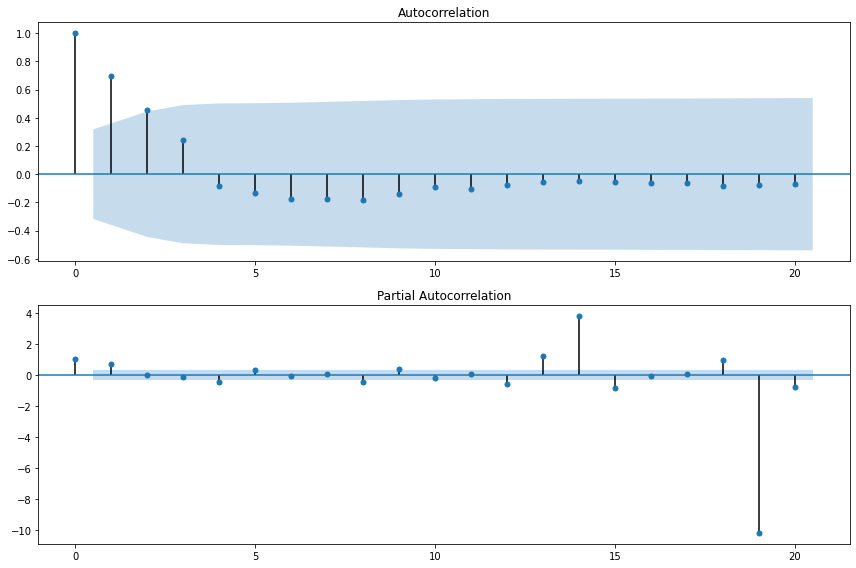

In [765]:
# Parameters of the ARIMA model were estimated by autocorrelation function (ACF) graph 
# and partial autocorrelation (PACF) correlogram.
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
 
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(log_series.diff(2).dropna(), lags=20,ax=ax1)
ax1.xaxis.set_ticks_position('bottom')
fig.tight_layout()

ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(log_series.diff(2).dropna(), lags=20, ax=ax2)
ax2.xaxis.set_ticks_position('bottom')
fig.tight_layout()
plt.show()

In [766]:
# AIC and BIC are standards for measuring the goodness of statistical model fit. 
# They were used to help model selection. 
import statsmodels.api as sm
ts = log_series
sm.tsa.arma_order_select_ic(ts,max_ar=6,max_ma=4,ic='aic')['aic_min_order'] 

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist

(1, 2)

In [767]:
sm.tsa.arma_order_select_ic(ts,max_ar=6,max_ma=4,ic='bic')['bic_min_order']

/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)
/usr/local/lib/python3.6/dist

(1, 2)

#### Model Evaluation

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


-------------------------------------------------
              prediction     test
date                             
2020-03-18  32241.708082  31506.0
2020-03-19  36178.553314  35713.0
2020-03-20  40944.042141  41035.0
2020-03-21  45923.066309  47021.0
2020-03-22  51495.174851  53578.0
-------------------------------------------------
Test MSE: 1261979.719
-------------------------------------------------
Test MAE: 894.596
-------------------------------------------------
Test RMSE: 1123.379
-------------------------------------------------


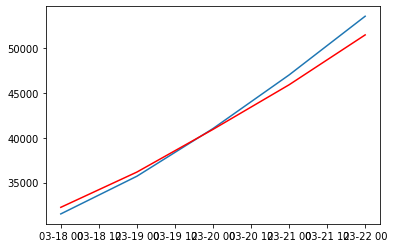

In [791]:
from sklearn.metrics import mean_squared_error
from sklearn import metrics
train = ts[:-5]
test = ts[-5:]
y_pred = np.exp(test.copy())
model = ARIMA(train, order=(1,2,2))
model = model.fit()
prediction = model.forecast(len(test))[0]

result = pd.DataFrame(np.exp(prediction), index = test.index, columns=['prediction'])
result['test'] = y_pred
print('-------------------------------------------------')
print(result)
print('-------------------------------------------------')
print('Test MSE: %.3f' % metrics.mean_squared_error(result['test'], result['prediction']))
print('-------------------------------------------------')
print('Test MAE: %.3f'% metrics.mean_absolute_error(result['test'], result['prediction']))
print('-------------------------------------------------')
print('Test RMSE: %.3f'% np.sqrt(metrics.mean_squared_error(result['test'], result['prediction'])))
print('-------------------------------------------------')

plt.plot(result['test'])
plt.plot(result['prediction'], color='red')
plt.show()

In [792]:
print(model.summary())
print(model.aic)
print(model.bic)
print(model.hqic)

                             ARIMA Model Results                              
Dep. Variable:         D2.total_cases   No. Observations:                   33
Model:                 ARIMA(1, 2, 2)   Log Likelihood                 -18.982
Method:                       css-mle   S.D. of innovations              0.423
Date:                Mon, 20 Apr 2020   AIC                             47.963
Time:                        00:35:59   BIC                             55.446
Sample:                             2   HQIC                            50.481
                                                                              
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                   -0.0031      0.052     -0.061      0.952      -0.105       0.099
ar.L1.D2.total_cases    -0.4989      0.199     -2.502      0.018      -0.890      -0.108
ma.L1.D2.tot

###### Model Evaluation - Residuals testing

<Figure size 864x576 with 0 Axes>

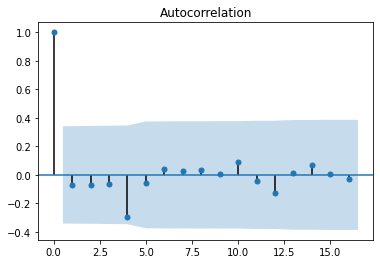

In [793]:
# Testing autocorrelation for residuals of the model
fig = plt.figure(figsize=(12,8))
fig = sm.graphics.tsa.plot_acf(model.resid.values.squeeze())
# By observing the autocorrelation function graph of the residual, 
# we can infer that there is no autocorrelation between the residual values.

In [794]:
# Testing the mean of the residuals is equal or close to 0
print(model.resid.describe())

count    33.000000
mean      0.011703
std       0.433471
min      -1.226522
25%      -0.044397
50%      -0.009899
75%       0.047404
max       1.901555
dtype: float64


In [795]:
# D-W test：（Durbin-Watson）test
# when DW=0 --> ρ＝1, residuls are positively autocorrelated 
# when DW=4 --> ρ＝-1, residuls are negatively autocorrelated
# when DW≈2 --> ρ＝0, no first-order autocorrelation between residuls
from scipy import  stats
print(sm.stats.durbin_watson(model.resid.values))
# The D-W test of the residuals of the ARIMA model is 2.118, it can be inferred that there is no autocorrelation.

2.118665315992234


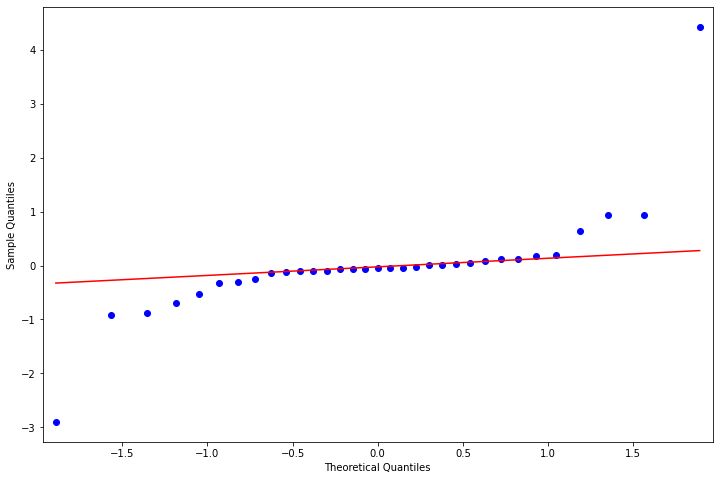

In [797]:
# Q-Q plot is also used to test whether the residuals are normally distributed.
from statsmodels.graphics.api import qqplot
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
fig = qqplot(model.resid, line='q', ax=ax, fit=True)
# According to the Q-Q plot of the residuals, we can infer that the residuals are normally distributed

# Predicting the cumulative confirmed cases in the future

In [805]:
pred_2 = model.forecast(len(test)+9)[0]
pred_2 = DataFrame(np.exp(pred_2))
print()
print('--------------------Values in the testset--------------------------------')
print(result['test'])
print()
print('--------------------Values in the near future----------------------------')
print(pred_2)


--------------------Values in the testset--------------------------------
date
2020-03-18    31506.0
2020-03-19    35713.0
2020-03-20    41035.0
2020-03-21    47021.0
2020-03-22    53578.0
Name: test, dtype: float64

--------------------Values in the near future----------------------------
                0
0    32241.708082
1    36178.553314
2    40944.042141
3    45923.066309
4    51495.174851
5    57478.345861
6    64001.296612
7    71014.773250
8    78563.214459
9    86632.938680
10   95235.454657
11  104360.672932
12  114001.943752
13  124141.658469
